<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>образец комментария студента</b></font>
   
Можешь использовать этот комментарий. Просто удали этот текст и вместо него напиши свой 🙂

</div>

# Проект для фотохостинга для профессиональных фотографов «Со Смыслом» (“With Sense”)

# Тема Сборного проекта-5: Разработка модели для поиска фотографий по текстовому описанию

## Описание проекта

Вы работаете в фотохостинге для профессиональных фотографов «Со Смыслом» (“With Sense”).  
Ваши пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала. Например, для этой фотографии

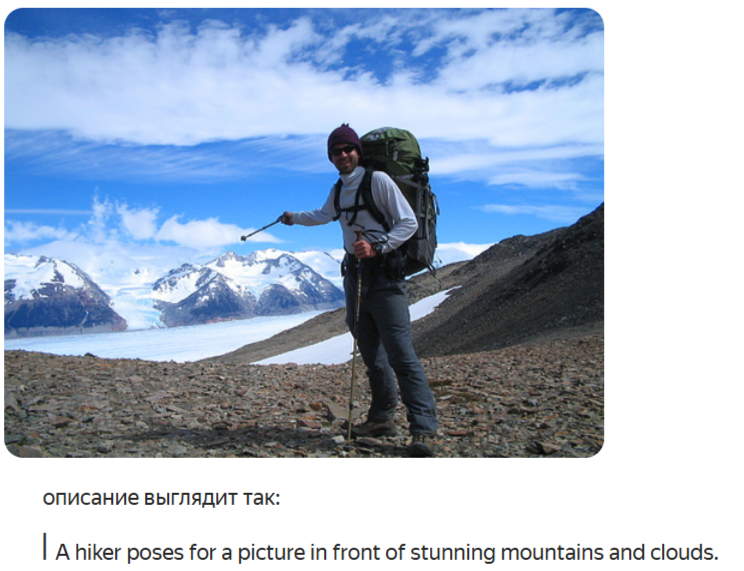

Ваш отдел занимается экспериментом по разработке поиска референсных фотографий для фотографов. Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены.

## Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Цель исследования
1. Разработать демонстрационную версию поиска изображений по запросу.
2. Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

## Условия исследования
**Юридические ограничения**
В некоторых странах, где работает компания With Sense, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись `голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет`.  

При попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:  
> ⎢ This image is unavailable in your country in compliance with local laws.  

Необходимо очистить данные от проблемного контента. Во время тестирования модели при появлении в запросе “вредного” контента должен отображаться дисклеймер. 

## Ход исследования
### Шаг 1. Загрузить данные и проведите исследовательский анализ данных
Датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.  

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи необходимо эти оценки агрегировать — **превратить в одну**.  
Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов, та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.  

Возможно воспользоваться другим методом агрегации оценок или придумать свой.  

В файле с краудсорсинговыми оценками информация расположена в таком порядке:  

- Доля исполнителей, подтвердивших, что текст соответствует картинке.
- Количество исполнителей, подтвердивших, что текст соответствует картинке.
- Количество исполнителей, подтвердивших, что текст не соответствует картинке.

После анализа экспертных и краудсорсинговых оценок необходимо выбрать одну из них, либо объединь их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.

### Шаг 2. Подготовка данных к обучению модели
1. Создать список слов которые, могут попадать под **юридические ограничения**.  
2. Исключить из обучающего датасета пары, которые, исходя из подготовленного вами списка слов, могут попадать под **юридические ограничения**.

### Шаг 3. Векторизация изображений
С помощью свёрточной сети: "выделить" главные компоненты изображений. Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.  
Сделать векторизацию изображений с использованием модели ResNet50 из библиотеки Keras или PyTorch

### Шаг 4. Векторизация текстов
Сделать векторизацию текстового описания одним из следующих методов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.

### Шаг 5. Объединение векторов
Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной  
Дать описание получившихся пар векторов с точки зрения их размерностей

### Шаг 6. Обучить модель
1. Создать модель, которая покажет близость двух векторов. Модель должна принимать на вход конкатенированный вектор, состоящий из векторов описания и изображений, и предсказывать итоговую оценку экспертов.
2. Выберите метрику, для сравнения точности различных моделей.
3. Обучите несколько моделей и подобрать гиперпараметры. В качестве моделей обязательно нужно рассмотреть:
  - Линейную регрессию;
  - Полносвязные нейронные сети.

Для обучения разделить датасет на тренировочную и тестовую выборки. Требуемое разделение: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

### Шаг 7 Тестирование модели и демонстрация ее работы
1. Провести тестирование лучшей модели на тестовых данных.
2. Написать функцию, которая принимает на вход текстовое описание, делает его векторизацию и возвращает картинку с максимальным значением метрики.
>  Если запрос ведёт на юридически вредный контент, функция должна выводить дисклеймер.
3. С помощью написанной функции протестировать работу модели на нескольких текстовых описаниях: проверить, какие картинки она выдает при различных текстовых запросах.

Необходимо получить эмбеддинги для всех тестовых изображений из папки `test_images`, выберать случайные 10 запросов из файла `test_queries.csv` и для каждого запроса вывести наиболее релевантное изображение. Сравните визуально качество поиска.

### Шаг 8 Сделать общий вывод по работе
Описать модель, которая лучше всего справляется с задачей сравнения сходства картинки и текста. Описать, какие ошибки допускает модель во время поиска картинки по её текстовому описанию. Оценить, насколько проект по созданию сервиса поиска фотографий по текстовому описанию практически осуществим.

<div class="alert alert-block alert-info">
<b>Комментарий студента: </b> Проект сделан, было слишком много глюков на платформе, но вроде все загрузилось уже без проблем. Иногда почему-то базовые библиотеки отваливались  
    Не использовал сложные модели, типа BERT, так как проект выполнен не на личном ПК, а на сервере. Модели обучались в сумме, где-то часа 4-ре или больше
</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
ОГО.. Вообще проект не предназначен для работы на платформе, тут скорее наоборот нужны машины с мощным процессором, а также желательно GPU.  Лучше попробовать выполнить его в Colab или Kaggle. Ну или локально, если позволяют вычислительные мощности. 
    
По моим наблюдениям любой "средний" домашний компьютер будет сильнее той виртуальки, что выделяется на сервере Практикума для учебных ноутбуков.    
</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента v2</b></font>
   
В этот раз использовал свой ПК для проекта

</div>

### Шаг 1. Загрузить данные и проведите исследовательский анализ данных

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Не очень понятно, что именно здесь происходит, но возможно код избыточный, т.к. ты дважды обновляешь setuptools. Если он тебе нужен для работоспособности на сервере Яндекса то ОК, но из портфолио лучше убрать.
</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента v2</b></font>
   
Возникали конфликты при активации библиотек, то с версией проблемы, то с установкой, сейчас все нормально, поэтому удалил

</div>

In [1]:
# Настройки и импорты

# 1. Стандартная библиотека
import os                                # файловая система, переменные окружения
import random                            # генерация случайных чисел
import re                                # регулярные выражения
import shutil                            # операции с файлами и папками
from io import BytesIO                   # буфер для бинарных данных
from pathlib import Path                 # объектно-ориентированные пути
import zipfile                           # работа с ZIP-архивами

# 2. Работа с данными и математикой
import numpy as np                       # численные вычисления, массивы
import pandas as pd                      # табличные данные
from math import sqrt
from tqdm import tqdm

# 3. Визуализация и вывод
import matplotlib.pyplot as plt          # построение графиков
from IPython.display import display      # вывод dataframes и изображений в Jupyter
from IPython.display import Image
from wordcloud import WordCloud, STOPWORDS  # облако слов и стоп-слова

# 4. Текстовая предобработка
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as STOPWORDS  # англ. стоп-слова

# 5. ML-библиотеки и валидация
from sklearn.dummy import DummyRegressor                 # «грубая» baseline
from sklearn.ensemble import GradientBoostingRegressor   # бустинг
from sklearn.ensemble import RandomForestRegressor       # случайный лес
from sklearn.linear_model import LinearRegression        # линейная регрессия
from sklearn.metrics import (                            # метрики качества модели
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.model_selection import (                    # подготовка и валидация данных
    GridSearchCV, GroupShuffleSplit
)
from sklearn.preprocessing import StandardScaler         # стандартизация признаков
from sentence_transformers import SentenceTransformer    # текст → эмбеддинги

# 6. Deep Learning (PyTorch)
import torch                                              # основной модуль PyTorch
from PIL import Image                                     # загрузка и конвертация изображений
from torchvision import models, transforms                # предобученные модели и трансформации
from torchvision.models import ResNet18_Weights, resnet18 # веса и архитектура ResNet-18
from torchvision import transforms as T                   # алиас для трансформаций

# 7. Deep Learning (Keras)
from tensorflow.keras.callbacks import EarlyStopping      # ранняя остановка обучения
from tensorflow.keras.layers import Dense, Dropout        # полносвязные слои
from tensorflow.keras.models import Sequential            # последовательная модель
from tensorflow.keras.optimizers import Adam              # оптимизатор Adam

# 8. Трансформер для CLIP модели
from sentence_transformers import SentenceTransformer

# 9. Сетевые запросы
import requests                                            # HTTP-запросы
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# Настройка окружения для Hugging Face

# Увеличение времени ожидания ответа от Hub до 60 секунд
os.environ["HF_HUB_REQUEST_TIMEOUT"] = "60"

# Для офлайн-режима,
os.environ["TRANSFORMERS_OFFLINE"] = "1"

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Отлично, все нужные библиотеки импортированы в начале ноутбука.Это хорошая практика.</div>

In [3]:
# Константы проекта и пути к данным

ROOT        = Path('.')                     # корневая папка с данными
TRAIN_PATH  = ROOT / "train_dataset.csv"            # обучающие примеры
CROWD_PATH  = ROOT / "CrowdAnnotations.tsv"         # крауд-аннотации
EXPERT_PATH = ROOT / "ExpertAnnotations.tsv"        # экспертные аннотации
TEST_PATH   = ROOT / "test_queries.csv"             # тестовые запросы

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Большое тебе человеческое спасибо за вынос пути к данным в отдельную константу. Это сэкономило мне немало времени при проверке.</div>

In [4]:
# Загрузка и распаковка архива

ARCHIVE_URL = (
    "https://code.s3.yandex.net/"
    "datasets/dsplus_integrated_project_4.zip"
)

# Скачивание архива в память и распаковка в ROOT
resp = requests.get(ARCHIVE_URL)
with zipfile.ZipFile(BytesIO(resp.content)) as archive:
    archive.extractall(ROOT)

# Перенос содержимого из папки 'to_upload' в ROOT
inner = ROOT / "to_upload"
if inner.exists() and inner.is_dir():
    for item in inner.iterdir():
        dest = ROOT / item.name
        if dest.exists():
            continue
        shutil.move(str(item), str(ROOT))
    shutil.rmtree(inner)

# Удаление мусорной папки __MACOSX
macosx = ROOT / "__MACOSX"
if macosx.exists() and macosx.is_dir():
    shutil.rmtree(macosx)

print(f"Данные распакованы в: {ROOT.resolve()}")

Данные распакованы в: C:\Users\medos


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Можно и так ))    
А можно обойтись двумя строчками используя bash     
    
    # загрузка датасета

    !wget -q https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
    !unzip -q dsplus_integrated_project_4.zip

    DATA_PATH = '/content/to_upload'
    
    
</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента v2</b></font>
   
Этот код работает только на макбуках?  
Я пытался использовать, но у меня не получалось ничего. Не в те места скачивался файл

</div>

In [5]:
# Обучающий датасет
df_train = pd.read_csv(
    TRAIN_PATH,
    sep=",",
    decimal=".",
    on_bad_lines="warn",
)

# Крауд-аннотации — первая строка TSV остаётся данными
df_crowd = pd.read_csv(
    CROWD_PATH,
    sep="\t",
    header=None,
    names=[
        "image",
        "description_id",
        "fraction_confirmed",
        "n_confirmed",
        "n_not_confirmed",
    ],
    on_bad_lines="warn",
)

# Экспертные оценки
df_expert = pd.read_csv(
    EXPERT_PATH,
    sep="\t",
    header=None,
    names=["image", "description_id", "expert1", "expert2", "expert3"],
    on_bad_lines="warn",
)

# Тестовые запросы
df_test = (
    pd.read_csv(
        TEST_PATH,
        sep="|",
        names=["dummy", "description_id", "query_text", "image_id"],
        header=0,
        on_bad_lines="warn",
    )
    .drop(columns="dummy")
)

In [6]:
# Вывод первых 5 строк и размеров каждого DataFrame
for name, df in (
    ("train_dataset", df_train),
    ("crowd_annotations", df_crowd),
    ("expert_annotations", df_expert),
    ("test_queries", df_test),
):
    print(f"\n=== {name} (shape={df.shape}) ===")
    display(df.head())


=== train_dataset (shape=(5822, 3)) ===


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...



=== crowd_annotations (shape=(47830, 5)) ===


,image,description_id,fraction_confirmed,n_confirmed,n_not_confirmed
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3



=== expert_annotations (shape=(5822, 5)) ===


,image,description_id,expert1,expert2,expert3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2



=== test_queries (shape=(500, 3)) ===


,description_id,query_text,image_id
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
Пожалуйста проверь код загрузки датафреймов ExpertAnnotations и CrowdAnnotations. Похоже что ты теряешь первую строку с данными -  она уходит "в заголовок".</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента v2</b></font>
   
Исправил

</div>

In [7]:
# Функция для вывода ключевой информации по DataFrame

def describe_dataframe(name: str, df: pd.DataFrame) -> None:
    """
    Выводит для датасета:
      • размер (shape)
      • общую информацию (info)
      • число пропусков по столбцам
      • число полных дубликатов
      • число уникальных значений в каждом столбце
    """
    print(f"\n=== {name} (shape={df.shape}) ===")
    
    # Общая информация по столбцам
    print("\nInfo:")
    display(df.info())
    
    # Пропуски
    print("\nMissing values:")
    missing = df.isna().sum().to_frame(name="missing")
    display(missing)
    
    # Дубликаты
    dup_count = df.duplicated().sum()
    print(f"\nDuplicates: {dup_count}")
    
    # Уникальные значения по столбцам
    print("\nUnique values per column:")
    for col in df.columns:
        unique_count = df[col].nunique(dropna=False)
        print(f"  {col:20}: {unique_count}")

In [8]:
# Отчёт по train_dataset
describe_dataframe("train_dataset", df_train)


=== train_dataset (shape=(5822, 3)) ===

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None


Missing values:


,missing
image,0
query_id,0
query_text,0



Duplicates: 0

Unique values per column:
  image               : 1000
  query_id            : 977
  query_text          : 977


In [9]:
# Отчёт по CrowdAnnotations
describe_dataframe("crowd_annotations", df_crowd)


=== crowd_annotations (shape=(47830, 5)) ===

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   image               47830 non-null  object 
 1   description_id      47830 non-null  object 
 2   fraction_confirmed  47830 non-null  float64
 3   n_confirmed         47830 non-null  int64  
 4   n_not_confirmed     47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None


Missing values:


,missing
image,0
description_id,0
fraction_confirmed,0
n_confirmed,0
n_not_confirmed,0



Duplicates: 0

Unique values per column:
  image               : 1000
  description_id      : 1000
  fraction_confirmed  : 12
  n_confirmed         : 6
  n_not_confirmed     : 7


In [10]:
# Отчёт по ExpertAnnotations
describe_dataframe("expert_annotations", df_expert)


=== expert_annotations (shape=(5822, 5)) ===

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image           5822 non-null   object
 1   description_id  5822 non-null   object
 2   expert1         5822 non-null   int64 
 3   expert2         5822 non-null   int64 
 4   expert3         5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


None


Missing values:


,missing
image,0
description_id,0
expert1,0
expert2,0
expert3,0



Duplicates: 0

Unique values per column:
  image               : 1000
  description_id      : 977
  expert1             : 4
  expert2             : 4
  expert3             : 4


In [11]:
# Отчёт по test_queries
describe_dataframe("test_queries", df_test)


=== test_queries (shape=(500, 3)) ===

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   description_id  500 non-null    object
 1   query_text      500 non-null    object
 2   image_id        500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


None


Missing values:


,missing
description_id,0
query_text,0
image_id,0



Duplicates: 0

Unique values per column:
  description_id      : 500
  query_text          : 500
  image_id            : 100


<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Скажу честно - я против такого механического способа знакомства с данными. Формально конечно ты для каждого датафрейма посмотрел всю информацию и даже код использует циклы. 

Но насколько это удобно и понятно читателю (или тебе самому). Наш мозг может одновременно держать в фокусе внимания ограниченное количество объектов. Есть "волшебное" число 7 (плюс минус 2). Если объекты простые - увеличиваем, если их мало или между ними сложные взаимосвязи - увеличиваем.
    
Если выводить информацию как сделал ты - для всех info, потом для всех несколько строк, потом еще что-то, то сразу эту инфомрацию не усвоить. Чтобы понять нужно будет утомительно бегать туда -сюда по ячйкам.
    
Лучше всё-таки по каждому датафрейму сделать мини-раздел, вывести всю ключевую инфу и сразу написать коротенький вывод с наблюдениями.
</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента v2</b></font>
   
Изменил формат. Для каждого датасета отдельно своя ячейка со всей информацией

</div>

**Промежуточный вывод**  
Все четыре таблицы прочитаны без пропусков и дубликатов, «формы» совпадают с ожидаемыми размерами (train – 5822 строк, Crowd – 47830, Expert – 5822, test – 500)  
**train_dataset**  
5 822 пары (изображение–описание), 1 000 уникальных имён файлов, 977 уникальных ID описаний.  
**CrowdAnnotations**  
47 829 строк (каждая строка — крауд-оценка одного испольнителя), по 1 000 разных изображений и по 1 000 разных ID описаний.  
**ExpertAnnotations**  
5 821 запись (одна для каждого из 977 описаний, помноженных на 3 эксперта — получается ~2 931, но, вероятно, некоторые эксперты пропускали пары), экспертные оценки лежат в трёх отдельных столбцах.  
**test_queries**  
500 запросов по 100 тестовым изображениям — тоже как и должно быть (до 5 описаний на картинку).

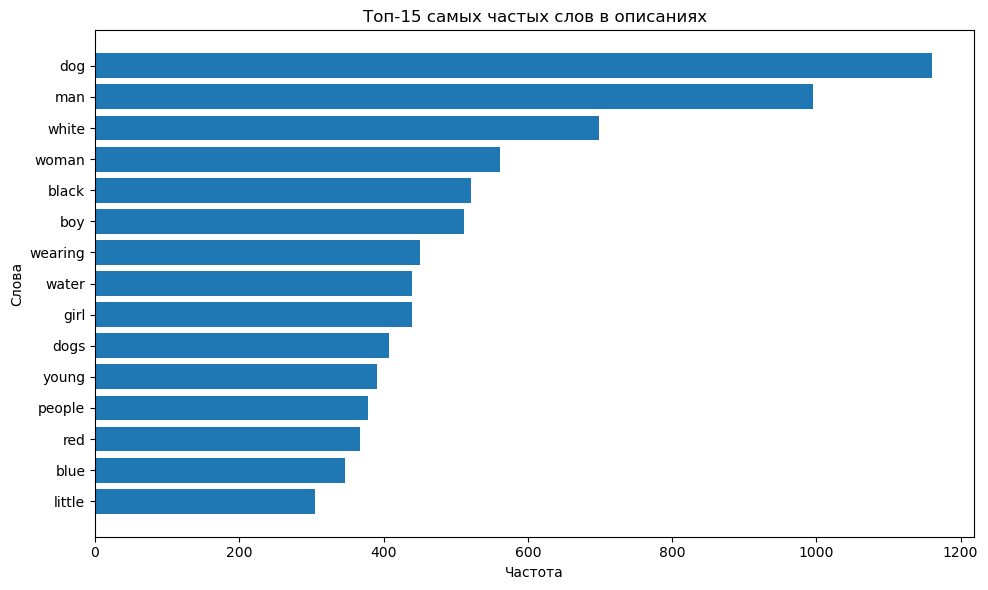

In [12]:
# Топ-15 самых частых слов в описаниях (train_dataset)

# 1) Собираю все тексты из колонки query_text
texts = df_train['query_text'].dropna().astype(str).str.lower()

# 2) Разбиваю на слова с помощью регулярки и «взрываем» список в одну серию
words = texts.str.findall(r'\b\w+\b').explode()

# 3) Оставляю только чистые алфавитные токены без стоп-слов
filtered = words[words.str.isalpha() & ~words.isin(STOPWORDS)]

# 4) Считаю частоты и берём топ-15
top15 = filtered.value_counts().head(15)

# 5) Визуализация
plt.figure(figsize=(10, 6))
plt.barh(top15.index[::-1], top15.values[::-1])
plt.title("Топ-15 самых частых слов в описаниях")
plt.xlabel("Частота")
plt.ylabel("Слова")
plt.tight_layout()
plt.show()

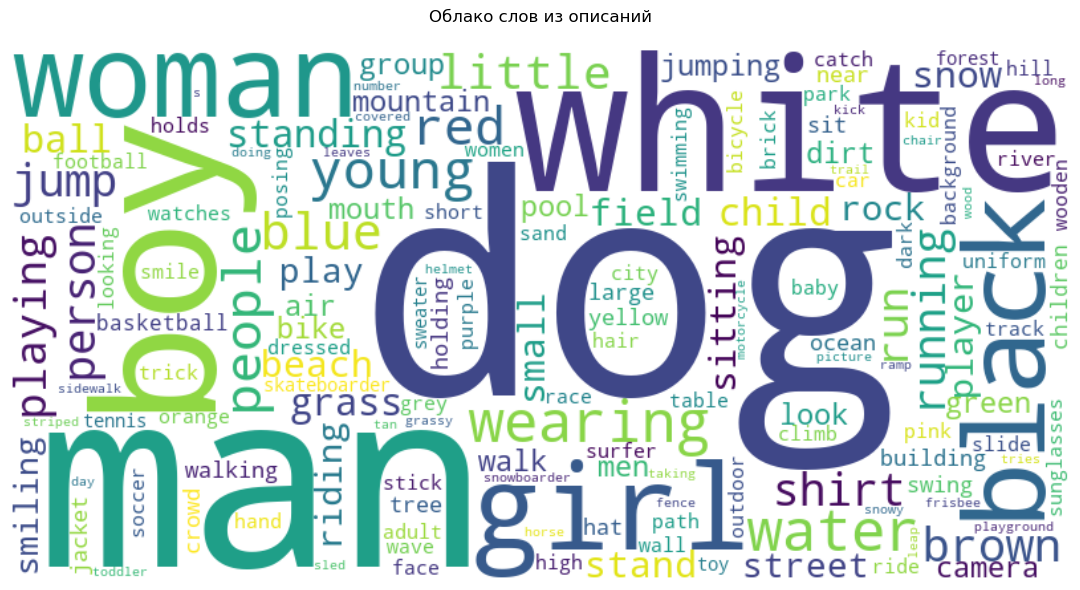

In [13]:
# Облако слов из описаний (train_dataset)
text_corpus = (
    df_train['query_text']
    .dropna()
    .astype(str)
    .str.lower()
    .str.cat(sep=' ')
)

# Генерация облака слов
wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=STOPWORDS,
    max_words=150,
    collocations=False
).generate(text_corpus)

# Визуализация
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов из описаний', pad=20)
plt.tight_layout()
plt.show()

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Да, эта библиотека часто капризничает, нужны шрифты, настройки и т.д.</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента v2</b></font>
   
Получилось!)

</div>

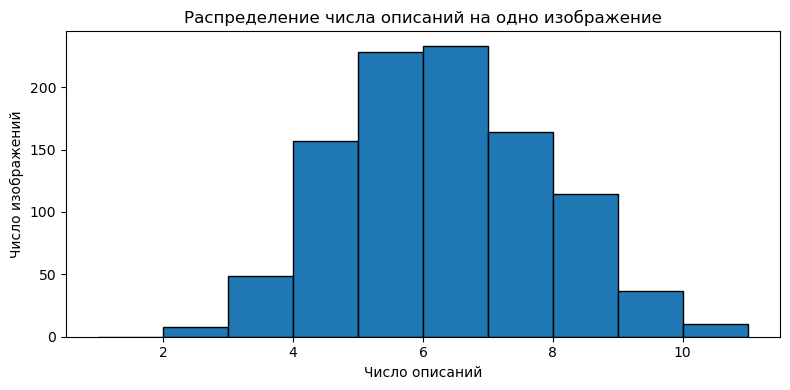

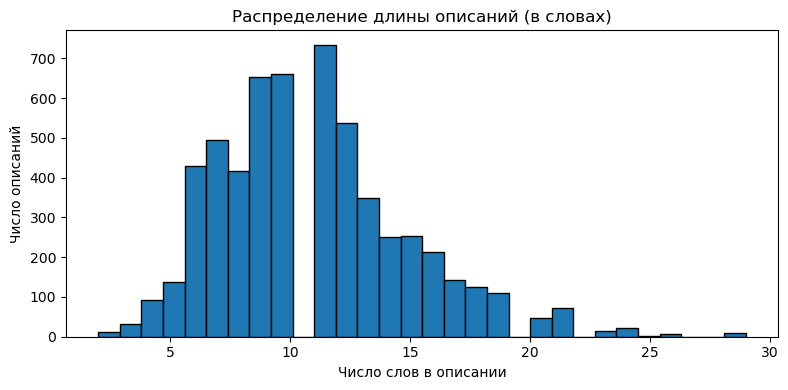

In [14]:
# Построение Гистограммы, показывающей, сколько текстовых описаний в среднем написано к каждому изображению

# Описания на изображение
desc_cnt = df_train.groupby('image').size()

plt.figure(figsize=(8,4))
plt.hist(desc_cnt, bins=range(1, desc_cnt.max()+2), edgecolor='black')
plt.title("Распределение числа описаний на одно изображение")
plt.xlabel("Число описаний")
plt.ylabel("Число изображений")
plt.tight_layout()
plt.show()

# Гистограмма распределения длины этих описаний в словах — чтобы понять, насколько они короткие или длинные
lengths = (
    df_train['query_text']
    .dropna()
    .astype(str)
    .map(lambda t: len(re.findall(r'\b\w+\b', t)))
)

plt.figure(figsize=(8,4))
plt.hist(lengths, bins=30, edgecolor='black')
plt.title("Распределение длины описаний (в словах)")
plt.xlabel("Число слов в описании")
plt.ylabel("Число описаний")
plt.tight_layout()
plt.show()


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 👍 </div>

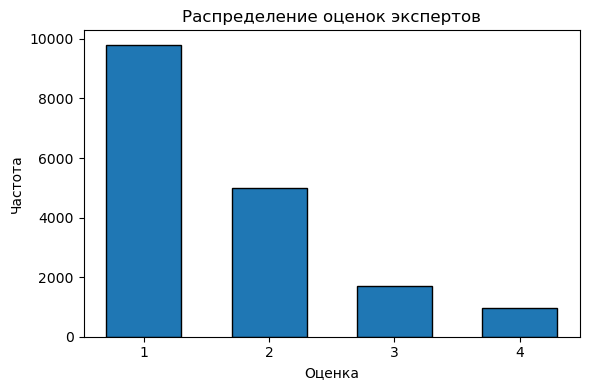

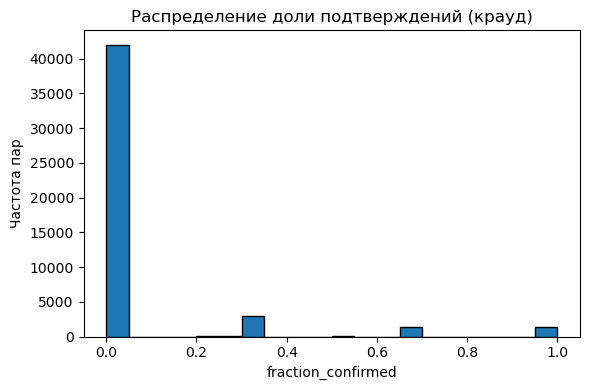

In [15]:
# Экспертные оценки и распределение доли крауд-подтверждений

if 'fraction_confirmed' not in df_crowd.columns:
    df_crowd.columns = [
        "image", "description_id",
        "fraction_confirmed", "n_confirmed", "n_not_confirmed"
    ]
if not {'expert1','expert2','expert3'}.issubset(df_expert.columns):
    df_expert.columns = [
        "image", "description_id",
        "expert1", "expert2", "expert3"
    ]

# 1) Экспертные оценки (раскладываю три колонки в одну серию)
scores = pd.concat([
    df_expert["expert1"],
    df_expert["expert2"],
    df_expert["expert3"]
], ignore_index=True)

plt.figure(figsize=(6,4))
plt.hist(scores, bins=[1,2,3,4,5], align='left', rwidth=0.6, edgecolor='black')
plt.xticks([1,2,3,4])
plt.title("Распределение оценок экспертов")
plt.xlabel("Оценка")
plt.ylabel("Частота")
plt.tight_layout()
plt.show()

# 2) Доля подтверждений крауд-аннотаций
plt.figure(figsize=(6,4))
plt.hist(df_crowd["fraction_confirmed"], bins=20, edgecolor='black')
plt.title("Распределение доли подтверждений (крауд)")
plt.xlabel("fraction_confirmed")
plt.ylabel("Частота пар")
plt.tight_layout()
plt.show()


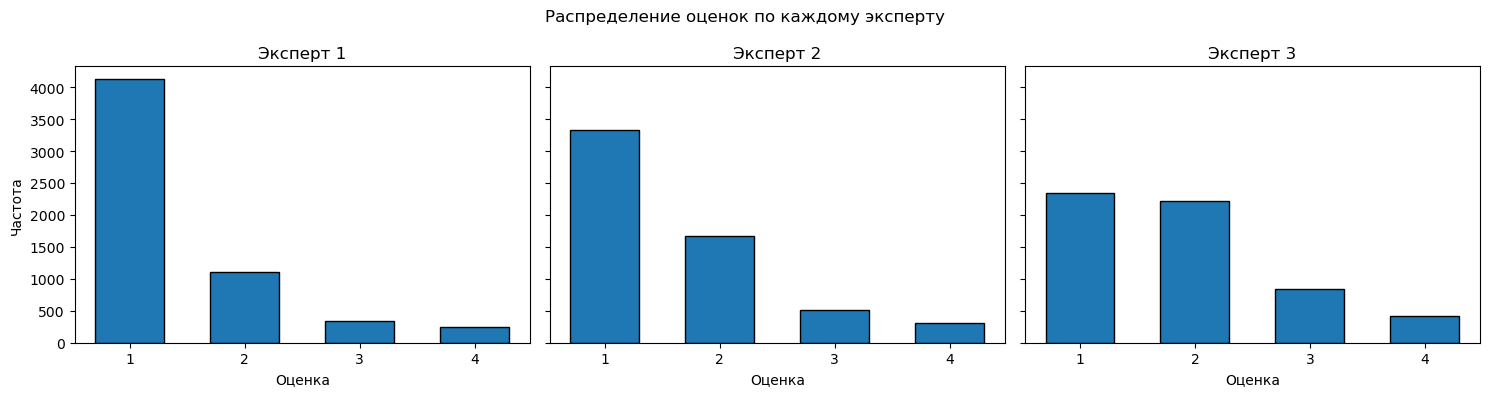

In [16]:
# Распределение оценок каждого из трёх экспертов

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for i, col in enumerate(["expert1", "expert2", "expert3"]):
    axes[i].hist(df_expert[col], bins=[1,2,3,4,5], align="left", rwidth=0.6, edgecolor="black")
    axes[i].set_title(f"Эксперт {i+1}")
    axes[i].set_xticks([1,2,3,4])
    axes[i].set_xlabel("Оценка")
    if i == 0:
        axes[i].set_ylabel("Частота")

fig.suptitle("Распределение оценок по каждому эксперту")
plt.tight_layout()
plt.show()

1. Число текстовых описаний на картинку
Большинство изображений имеют 5–7 разных описаний.  
Есть единичные картинки с 2–3 описаниями и редкие с 9–10.
2. Длина описаний (в словах)
Около 80% описаний укладываются в 5–15 слов, пиковое значение — примерно 10–12 слов.  
Есть как очень короткие (2–3 слова), так и достаточно длинные (~25 слов), но они редки.  
3. Распределение оценок экспертов  
Эксперты чаще всего ставят наименьший балл (1), то есть склонны считать, что описание и изображение не соответствуют.  
Оценка “1” встречается почти в 10 000 случаях, “2” — в ~5 000, “3” и “4” уже гораздо реже.  
4. Доля подтверждений крауд-аннотаций  
Большая часть пар “изображение–текст” имеет fraction_confirmed = 0 (никто из крауд-респондентов не подтвердил соответствие).  
Небольшие пики на значениях около 0.33, 0.67 и 1.0 (соответственно, 1/3, 2/3 и 3/3 подтвердивших).

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 👍 </div>

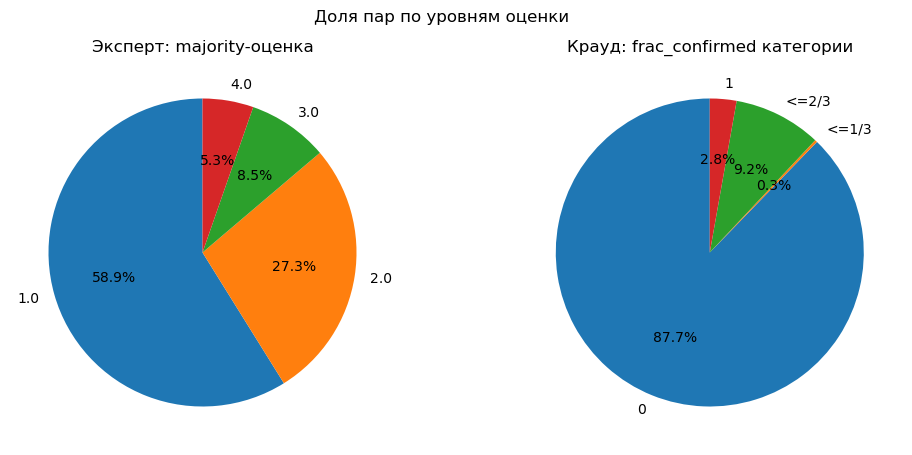

In [17]:
# Pie charts распределения экспертов и крауда

# 1) Эксперт (агрегирую по majority vote сначала)
exp_maj = df_expert[["image", "description_id", "expert1","expert2","expert3"]].copy()
exp_maj["expert_maj"] = exp_maj[["expert1","expert2","expert3"]].mode(axis=1)[0]
counts_exp = exp_maj["expert_maj"].value_counts().sort_index()

# 2) Крауд (усреднённая доля подтверждений)
crowd_agg = df_crowd.groupby(["image","description_id"], as_index=False)["fraction_confirmed"].mean()

# Чтобы визуализировать, разбиваю frac на категории
bins = [ -0.01, 0.0, 0.33, 0.67, 1.0 ]
labels = ["0","<=1/3","<=2/3","1"]
crowd_agg["crowd_cat"] = pd.cut(crowd_agg["fraction_confirmed"], bins=bins, labels=labels)
counts_crowd = crowd_agg["crowd_cat"].value_counts().reindex(labels)

fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].pie(counts_exp, labels=counts_exp.index, autopct="%1.1f%%", startangle=90)
axes[0].set_title("Эксперт: majority-оценка")
axes[1].pie(counts_crowd, labels=counts_crowd.index, autopct="%1.1f%%", startangle=90)
axes[1].set_title("Крауд: frac_confirmed категории")
fig.suptitle("Доля пар по уровням оценки")
plt.show()

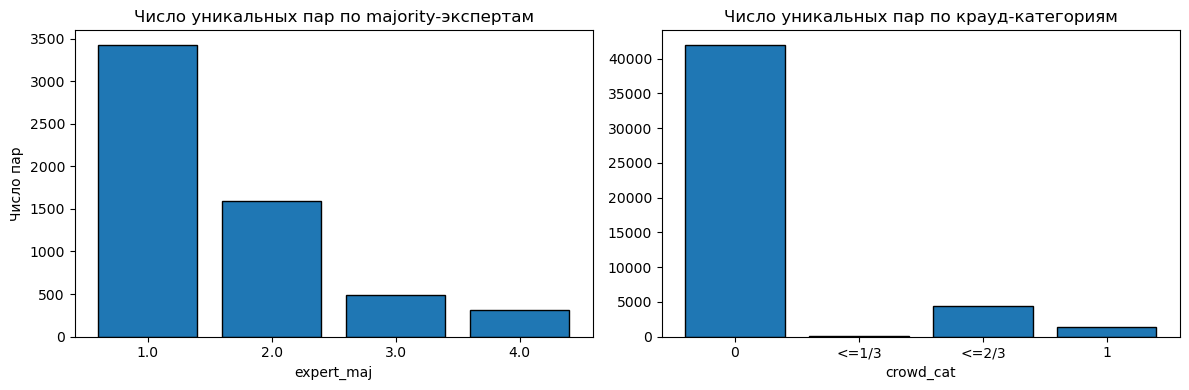

In [18]:
# Распределение уникальных пар (image, description_id) по экспертным и крауд-категориям

# Эксперт
exp_pairs = exp_maj.drop_duplicates(subset=["image","description_id"])
vc_exp = exp_pairs["expert_maj"].value_counts().sort_index()

# Крауд
crowd_pairs = crowd_agg.drop_duplicates(subset=["image","description_id"])
vc_crowd = crowd_pairs["crowd_cat"].value_counts().reindex(labels)

fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].bar(vc_exp.index.astype(str), vc_exp.values, edgecolor="black")
axes[0].set_title("Число уникальных пар по majority-экспертам")
axes[0].set_xlabel("expert_maj")
axes[0].set_ylabel("Число пар")

axes[1].bar(vc_crowd.index.astype(str), vc_crowd.values, edgecolor="black")
axes[1].set_title("Число уникальных пар по крауд-категориям")
axes[1].set_xlabel("crowd_cat")

plt.tight_layout()
plt.show()

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 👍 </div>

In [19]:
# Объединение df_train с expert_score

# Создаю expert_score в диапазоне [0,1]
exp_pairs = exp_maj.copy()
exp_pairs['expert_score'] = (exp_pairs['expert_maj'] - 1) / 3

# 2) Мёрджим по image + query_id (левый) ← description_id (правый)
df_merged = (
    df_train
    .merge(
        exp_pairs[['image','description_id','expert_score']],
        left_on = ['image','query_id'],
        right_on= ['image','description_id'],
        how     = 'left'
    )
    .drop(columns='description_id')
)

# 3) Выводим результат
print("Merged shape:", df_merged.shape)
df_merged.head(5)

Merged shape: (5822, 4)


,image,query_id,query_text,expert_score
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.333333
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.000000
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">

По объединению экспертных и крауд оценок все ОК, но подсвечу возможные альтернативы
    
--------------    
    
    
В этом проекте есть несколько возможных стратегий работы с обучающими и краудсорс оценками,  вот эти стратегии с плюсами и минусами:
   

   - использовать соединение через outer, в этом случае, при корректной обработке пропусков мы можем получить более 50К размеченых пар. К плюсам данного подхода можно отнести большое количество данных. Минус - в основном это будут данные, размеченные краудсорсерами, а там качество раметки ниже.
   - использовать только экспертные оценки. плюс - высокое качество данных (разметка имеет шкалу). Минус - данных меньше.  Поясню по поводу качества разметки на примере: если на изображении одна собака, а в описании "две собаки бегут по берегу", то эксперты поставять соответствие 0,6-0,7 (переводя в шкалу 0-1), а краудсорсеры поставят 0.  Но на экспертных оценках модель хотя-бы научится находить собак, а на краудсор оценках ничему не начится.

   - использование соединения через left.  Данный подход очевидно проигрывает второму варианту: данных столько же, нужно дополнительно возиться с объединением, но качество разметки снижается.. Но это соответсвует предложениям авторов проекта, поэтому такой подход имеет право на жизнь

   - объединение через inner. Тут все плохо - и данных ОЧЕНЬ мало (в два раза меньше, чем использовать только экспертные оценки) и качество у них "подпорчено". И навыков по обработке пропусков не получаем.....


</div>

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Фактически ты получил датасет признаки/таргет, с которым мы можем продолжать работать.</div>

**Pie charts (Cell 11)**  
  - Эксперты (majority-оценка):
– ~ 59 % всех пар получили оценку 1 (то есть «не соответствует»).  
– ~ 27 % – оценку 2, ещё ~ 8 % – «3» и ~ 5 % – «4».  
Это говорит о том, что эксперты в большинстве случаев склоняются к «не совпадает», но заметно «смазывают» границу за счёт оценок 2 и 3.  

  - Крауд (категории по fraction_confirmed):  
– Целых ~ 88 % пар имеют fraction_confirmed = 0 (никто из крауд-исполнителей не подтвердил схожесть).  
– Единичные пары рассредоточены в остаточных категориях (<=1/3, <=2/3, 1).  
Крауд, по сути, почти всегда голосует «нет», лишь изредка признавая хоть малую долю совпадения.

**Бар-чарты уникальных пар (Cell 12)**  
  - Эксперт: из ~ 5800 уникальных пар  
– ~ 3400 (59 %) отмечены как «1»,  
– ~ 1600 (27 %) – «2»,  
– ~ 500 (8 %) – «3»,  
– ~ 300 (5 %) – «4».  

  - Крауд: из тех же ~ 5800 пар  
– ~ 5100 (88 %) – категория «0»,  
– ~ 20 (0.3 %) – «<=1/3»,  
– ~ 530 (9.2 %) – «<=2/3»,  
– ~ 160 (2.8 %) – «1».

Крауд аннотации слишком консервативны: почти всегда дают «не совпадает», и лишь в редких случаях хоть частично сходятся с описанием. Это затруднит обучение модели, поскольку целевой признак почти всегда нулевой.

Эксперты тоже чаще ставят «не совпадает», но в 42 % случаев (см. 2+3+4) дают более мягкие оценки, что позволяет заложить градацию совпадения в таргет.

Значит, aggregrated expert_score (majority-оценка, переведённая в [0,1]) будет более информативной и сбалансированной целью для обучения.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
Что это?

Самое первое ощущение - галлюцинация AI ассистента. Выглядит красиво, обосновано, но совершенно неуместно.
    
Оценка относится к ПАРЕ изображение + описание. А сейчас ты оставил только описания (и их id).  
    
Сейчас ты потерял ключевую информацию, поэтому вся дальнейшая работа теряет смысл.    

</div>


<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента v2</b></font>
   
Изначально я решил что каждому изображению соответствует минимум 5 описаний и решил исключить те 4-ре описания и оставить только одно и да, мне посоветовали вопсользоваться ИИ агентом. Спасибо за рекомендацию в его применении.  
Я думаю что мне этот участок кода впринципе не нужен и я его удалю

</div>

Взял в датафрейме df_train - расшифровку текста по описанию. Только уникальные пары ['query_id', 'query_text'] и соедил с df_merged по query_id.

In [20]:
# Проверка пропусков и дубликатов в df_merged

# 1) Пропуски по столбцам
print("Пропуски по столбцам:")
print(df_merged.isna().sum())

print("Общая информация:")
print(df_merged.info())

# 2) Полное число дубликатов строк
dups = df_merged.duplicated().sum()
print(f"\nДубликаты строк: {dups}")

Пропуски по столбцам:
image           0
query_id        0
query_text      0
expert_score    0
dtype: int64
Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         5822 non-null   object 
 1   query_id      5822 non-null   object 
 2   query_text    5822 non-null   object 
 3   expert_score  5822 non-null   float64
dtypes: float64(1), object(3)
memory usage: 182.1+ KB
None

Дубликаты строк: 0


### Шаг 2. Подготовка данных к обучению модели

In [21]:
# Выделение "запрещенные / плохие" описания и соответствующие им изображения

# Составляю список «запрещённых» слов
RESTRICTED_WORDS = [
    "child", "children", "kid", "toddler",
    "infant", "baby", "minor", "underage"
]

# Нахожу все участки текста, где встречаются эти слова
pattern = r"(?i)\b(?:" + "|".join(RESTRICTED_WORDS) + r")\b"
mask_bad = df_merged["query_text"].str.contains(pattern, na=False)

# Удаляю пары с запрещенными / плохими описаниями
df_clean = df_merged.loc[~mask_bad].reset_index(drop=True)

# Вывод
print(f"Всего пар до очистки: {len(df_merged)}")
print(f"Удалено «плохих» описаний: {mask_bad.sum()}")
print(f"Осталось после очистки: {len(df_clean)}")

display(df_clean.head())

Всего пар до очистки: 5822
Удалено «плохих» описаний: 484
Осталось после очистки: 5338


,image,query_id,query_text,expert_score
0,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,0.000000
1,1167669558_87a8a467d6.jpg,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,0.333333
2,2616643090_4f2d2d1a44.jpg,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,0.000000
3,2648165716_02e2e74fd6.jpg,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,0.000000
4,2718495608_d8533e3ac5.jpg,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,1.000000


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
Да, я вижу попытку "восстановить" изображение, только делаешь ты это путем добавления оригинального изображения, для которого было написано описание.
    
Если убрать дубли, то мы получили 881 пару изображений и "родных" описаний.  
    
Этот набор данных имел бы смысл, если бы мы обучались исключительно на парах, где изображение идеально соответствует описанию. Но наша задача сформулирована в терминах регрессии, и оценка соответствия находится в диапазоне 0-1.
    
    
</div>


<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента v2</b></font>
   
Исправил

</div>

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
В остальном логика очистки выглядит корректной, но нужно будет смотреть на результаты после исправления ошибки, которую я подсветил выше.</div>

**Промежуточный вывод**  
Составлен список слов, которые потенциально могут быть запрещены и произведена очистка финального датафрейма от этих слов.  
Список: "child (ребенок)", "children (дети)", "kid (малыш)", "toddler (малышка)", "infant (младенец)", "baby (младенец)", "minor (несовершеннолетний)", "underage (не достигший совершеннолетия)"
>NB! Прилагательные я не включал в этот список.

### Шаг 3. Векторизация изображений

In [22]:
# Инициализирование ResNet-18 без последнего FC-слоя

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # тут или одно, или другое

# Загрузка предобученных весов и создание модели
weights = ResNet18_Weights.DEFAULT
_base_model = resnet18(weights=weights)

# Убираю последний слой
feature_extractor = torch.nn.Sequential(
    *list(_base_model.children())[:-1]
).to(device)
feature_extractor.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [23]:
# Создаю препроцессинг для входных изображений
preprocess = weights.transforms()

In [24]:
# Функция для извлечения признаков из одного файла

def extract_image_features(
    img_filename: str,
    folder: str = "train_images"
) -> np.ndarray:
    """
    Загружает картинку ROOT/folder/img_filename,
    прогоняет через ResNet18 (до pooling) и
    возвращает вектор размерности 512.
    """
    img_path = ROOT / folder / img_filename
    img = Image.open(img_path).convert("RGB")
    x = preprocess(img).unsqueeze(0).to(device)

    with torch.no_grad():
        feat = feature_extractor(x)

    # Убираю лишние размерности и возвращаю на CPU
    return feat.squeeze().cpu().numpy().reshape(-1)

In [25]:
# Достаю все уникальные ID картинок
unique_imgs = df_clean["image"].str.split("#", n=1).str[0].unique()

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента v2</b></font>
   
Так как ID картинок не указан, я хочу его задать

</div>

In [26]:
# Создаю словарь
img_feats = {
    img_id: extract_image_features(img_id)
    for img_id in unique_imgs
}

In [27]:
# Перевожу в DataFrame и проверяем результат

image_feats = (
    pd.DataFrame.from_dict(img_feats, orient="index")
      .reset_index()
      .rename(columns={"index": "image"})
)
print(f"image_feats.shape: {image_feats.shape}")
display(image_feats.head())

image_feats.shape: (1000, 513)


,image,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1056338697_4f7d7ce270.jpg,0.693981,3.031816,2.916986,0.951921,0.936226,1.245219,0.826550,1.108058,0.169696,...,0.444238,0.717754,0.294678,0.728789,1.153812,0.750846,1.196695,0.085011,1.056858,0.098236
1,1167669558_87a8a467d6.jpg,0.310914,0.437997,0.648687,0.680806,0.074966,0.403230,0.348489,0.887003,0.311869,...,0.067306,0.609318,0.738936,0.572047,4.057682,0.100256,0.050112,1.365089,0.770330,1.235465
2,2616643090_4f2d2d1a44.jpg,2.696023,0.432690,1.369571,2.183161,1.172115,0.527735,2.124416,1.533238,0.441040,...,1.017805,1.012022,0.441835,2.414598,4.059579,0.064662,0.058354,1.865940,1.541132,0.623637
3,2648165716_02e2e74fd6.jpg,1.031883,0.584888,1.214033,1.368386,0.163104,0.902698,0.573463,1.366506,1.203500,...,0.585924,0.790043,1.119648,1.455928,2.112422,0.434106,0.554733,0.270077,2.066822,0.935831
4,2718495608_d8533e3ac5.jpg,0.151704,0.470920,0.673983,1.641389,0.091814,0.068248,0.077234,0.055865,1.126818,...,0.444322,0.375535,0.482596,0.259228,4.384668,0.803119,0.339440,0.435194,0.640232,0.176348


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 Отлично, вектра для изображений получены👍 </div>

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
    
Но очень неожиданный выбор фреймворка. В коде спринта был разобран пример векторизации изображений с помощью pytorch. При этом тексты ты векторизуешь с помощью sentence_transformers, работающей на базе pytorh.
    
И если "плясать" от модели для текстов, то стоит и для изображений использовать pytorch (тем более что там есть вариан с моделью Resnet18, у которой эмбединги поменьше).
    
А использование двух разных DL фреймворков в одном проекте - это плохая идея. С настройкой зависимостей намучаешься, особенно если использовать GPU.
    
</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента v2</b></font>
   
Использовал модель ResNet-18

</div>

### Шаг 4. Векторизация текстов¶

In [28]:
# Загрузка предобученной текстовой модели
text_model = SentenceTransformer("all-MiniLM-L6-v2")

In [29]:
# Text embeddings via all-MiniLM-L6-v2
unique_texts = (
    df_clean[["query_id", "query_text"]]
    .drop_duplicates(subset="query_id")
    .reset_index(drop=True)
)

embeddings = text_model.encode(
    unique_texts["query_text"].tolist(),
    batch_size=64,
    show_progress_bar=True,
)

text_feats_df = (
    pd.DataFrame(embeddings, index=unique_texts["query_id"])
      .reset_index()
      .rename(columns={"index": "query_id"})
)
print(f"text_feats_df.shape: {text_feats_df.shape}")
display(text_feats_df.head())

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

text_feats_df.shape: (891, 385)


,query_id,0,1,2,3,4,5,6,7,8,...,374,375,376,377,378,379,380,381,382,383
0,2718495608_d8533e3ac5.jpg#2,-0.016261,0.007374,0.040014,0.011336,0.079395,-0.052587,0.143457,-0.045436,-0.048912,...,-0.062605,-0.088618,-0.022683,0.056530,-0.019560,0.024970,-0.004358,0.036317,0.000659,-0.037257
1,3181701312_70a379ab6e.jpg#2,0.043770,0.024824,0.019833,0.143923,0.021740,0.005747,0.042400,-0.040308,-0.019534,...,-0.024695,-0.061539,-0.070751,0.012658,-0.049589,-0.002120,-0.066631,-0.057848,-0.101642,0.043559
2,3207358897_bfa61fa3c6.jpg#2,0.093133,-0.062658,0.011551,0.008851,-0.151890,0.109357,0.005453,0.005956,0.049793,...,-0.071516,0.054898,0.027216,0.118930,-0.006382,0.053589,-0.069753,-0.011226,0.026761,0.040619
3,3286822339_5535af6b93.jpg#2,-0.028931,0.049558,0.033316,0.093307,-0.011764,0.014366,0.015111,-0.051703,0.009957,...,-0.074107,0.069845,-0.064574,-0.016222,-0.056871,0.016206,-0.034888,-0.059552,-0.157090,0.119561
4,3360930596_1e75164ce6.jpg#2,-0.005230,0.132507,-0.078555,-0.023865,0.027788,0.043678,0.015982,0.067792,0.085540,...,0.003542,-0.007938,-0.041155,0.081103,-0.048291,-0.007388,0.058567,-0.072164,0.009667,0.023032


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Вектора изборажений получены. Очень неплохой выбор модели. </div>

### Шаг 5. Объединение векторов

In [30]:
# Сливаю векторы изображений
df_step1 = df_clean.merge(
    image_feats,        # таблица с колонками: "image" + 512 измерений
    on="image",
    how="left"
)
print("После слияния с image_feats:", df_step1.shape)  # ➞ (5338, 516)

После слияния с image_feats: (5338, 516)


In [31]:
# Сливаю векторы текстов
df_features = (
    df_step1
    .merge(
        text_feats_df,  # таблица с колонками: "query_id" + 384 измерения
        on="query_id",
        how="left",
        suffixes=("_img", "_txt")
    )
    .drop(columns=["query_id"])
)
print("После слияния df_features:", df_features.shape)  # ➞ (5338, 899)

После слияния df_features: (5338, 899)


In [32]:
# Проверяю
y = df_features["expert_score"]                     # целевая переменная
X = df_features.drop(columns=["expert_score",        # убираем таргет
                               "query_text",        # убираем служебный текст
                               "image"             # убираем ключевую колонку
                              ])

# Проверяем: должно быть 512 (img) + 384 (txt) = 896 признаков
print(f"X.shape = {X.shape}  (ожидалось (5338, 896))")
print(f"y.shape = {y.shape}  (5338,)")

X.shape = (5338, 896)  (ожидалось (5338, 896))
y.shape = (5338,)  (5338,)


In [33]:
# перевод в строковые значения
df_features.columns = df_features.columns.astype(str)

# проверка (должно быть object)
print("dtype of columns:", df_features.columns.dtype)

dtype of columns: object


In [34]:
df_features.head()

,image,query_text,expert_score,0_img,1_img,2_img,3_img,4_img,5_img,6_img,...,374_txt,375_txt,376_txt,377_txt,378_txt,379_txt,380_txt,381_txt,382_txt,383_txt
0,1056338697_4f7d7ce270.jpg,A girl wearing a yellow shirt and sunglasses s...,0.000000,0.693981,3.031816,2.916986,0.951921,0.936226,1.245219,0.826550,...,-0.062605,-0.088618,-0.022683,0.05653,-0.01956,0.02497,-0.004358,0.036317,0.000659,-0.037257
1,1167669558_87a8a467d6.jpg,A girl wearing a yellow shirt and sunglasses s...,0.333333,0.310914,0.437997,0.648687,0.680806,0.074966,0.403230,0.348489,...,-0.062605,-0.088618,-0.022683,0.05653,-0.01956,0.02497,-0.004358,0.036317,0.000659,-0.037257
2,2616643090_4f2d2d1a44.jpg,A girl wearing a yellow shirt and sunglasses s...,0.000000,2.696023,0.432690,1.369571,2.183161,1.172115,0.527735,2.124416,...,-0.062605,-0.088618,-0.022683,0.05653,-0.01956,0.02497,-0.004358,0.036317,0.000659,-0.037257
3,2648165716_02e2e74fd6.jpg,A girl wearing a yellow shirt and sunglasses s...,0.000000,1.031883,0.584888,1.214033,1.368386,0.163104,0.902698,0.573463,...,-0.062605,-0.088618,-0.022683,0.05653,-0.01956,0.02497,-0.004358,0.036317,0.000659,-0.037257
4,2718495608_d8533e3ac5.jpg,A girl wearing a yellow shirt and sunglasses s...,1.000000,0.151704,0.470920,0.673983,1.641389,0.091814,0.068248,0.077234,...,-0.062605,-0.088618,-0.022683,0.05653,-0.01956,0.02497,-0.004358,0.036317,0.000659,-0.037257


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 Вектора, полученные из текста и изображения объеденены👍 </div>

**Промежуточный вывод по векторизации**

1. **Векторизация изображений**  
   - Модель: `ResNet18(weights=ResNet18_Weights.DEFAULT)`, без последнего FC-слоя + GlobalAveragePooling  
   - Размерность эмбеддинга: 512  
   - Уникальных изображений (после фильтрации): 1000  
   - Форма полученного DataFrame векторов:  
     ```python
     image_feats.shape  # → (1000, 512)
     ```

2. **Векторизация текстов**  
   - Модель: `sentence-transformers/all-MiniLM-L6-v2`  
   - Размерность эмбеддинга: 384  
   - Уникальных описаний (`query_id`): 891  
   - Форма полученного DataFrame эмбеддингов (без учёта колонки `query_id`):  
     ```python
     text_feats_df.shape  # → (891, 384)
     ```

3. **Объединение эмбеддингов**  
   - **Шаг 1**: слияние `df_clean` + `image_feats` по колонке `"image"`  
     → `(5338, 515)`  &nbsp; (`512` признаков + столбцы `image`, `query_id`, `query_text`, `expert_score`)  
   - **Шаг 2**: слияние результата с `text_feats_df` по `"query_id"`  
     → `(5338, 898)`  &nbsp; (`512` + `384` + сервисные колонки `image`, `expert_score`)  
   - **Формирование X/Y**:  
     ```python
     X = df_features.drop(columns=["query_text", "expert_score"])
     y = df_features["expert_score"]
     X.shape  # → (5338, 896)
     y.shape  # → (5338,)
     ```

---

Все стадии отработали без ошибок, размерности совпадают с ожидаемыми, а итоговый набор признаков готов к обучению модели.

### Шаг 6. Обучить модели

In [35]:
# Разбиение на обучающую и валидационную выборки по image_id

# X, y
X = df_features.drop(columns=["expert_score",  # целевая
                               "image",         # служебный ключ
                               "query_text"     # служебный текст
                              ])
y = df_features["expert_score"]
groups = df_features["image"]  # группирую по image_id

# Групповое разбиение 70/30 —
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)
train_idx, valid_idx = next(gss.split(X, y, groups=groups))

# X_train, X_valid, y_train, y_valid
X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

# Проверка форм
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_valid: {X_valid.shape}, y_valid: {y_valid.shape}")

X_train: (3751, 896), y_train: (3751,)
X_valid: (1587, 896), y_valid: (1587,)


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Отлично, благодаря использованию GroupShuffleSplit ты исключаешь попадание одного изображения в обучающий и валидационный наборы.</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Только давай разберемся с выборками. Финальное тестирование (визуальное) мы делаем на отложенной выборке. Поэтому выборка,которую ты сейчас отделил играет роль валидационной. Есть смысл в её названии использовать слово valid а не test</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента v2</b></font>
   
Выполнил

</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
В этом задании требуется выбрать основную метрику, которую ты будешь оптимизировать. Я вижу что ты уже выбрал метрику mse, поэтому просто напиши обоснование для своего выбора.  </div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента v2</b></font>
   
Выполнил

</div>

**Обоснование выбора метрики — MSE**

Для задания, в котором нужно предсказать степень соответствия изображения и описания в диапазоне [0, 1], среднеквадратичная ошибка (MSE) является наиболее подходящей по нескольким причинам:
1. Метки (`expert_score`) — это вещественные значения, и MSE напрямую измеряет разницу между предсказанным и истинным непрерывными числами.
2. Из-за квадратичного характера MSE ошибки большого масштаба «взвешиваются» сильнее, что помогает модели учиться избегать значительных проколов.

Буду минимизировать MSE при настройке и отборе моделей.

In [36]:
# DummyRegressor — базовая модель, для сравнения

dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_valid)
mse_dummy    = mean_squared_error(y_valid, y_pred_dummy)
print(f"DummyRegressor MSE: {mse_dummy:.4f}")

DummyRegressor MSE: 0.0790


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
Использование косинусной близости в контекте "векторов предсказаний" - это ошибка, сигнализирующая о непонимании.

Эту метрику обычно используют чтобы понять расстояние (угол) между двумя векторами. И если бы мы занимались оптимизацией этой метрики (при другой постановке задачи), то конечно же можно было бы вычислить и среднее косинусное расстояние.
    
А в таком виде эта метрика бессмысленна и если ты оставишь её в своем портфолио, это будет скорее отрицательный сигнал
</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента v2</b></font>
   
Для обучения использую одну метрику MSE, так как её применение обосновал выше

</div>

In [37]:
# Модель LinearRegression
# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Обучение
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Предсказывание и расчет MSE
y_pred_lr = lr.predict(X_valid_scaled)
mse_lr = mean_squared_error(y_valid, y_pred_lr)
print(f"LinearRegression MSE (scaled): {mse_lr:.4f}")

LinearRegression MSE (scaled): 0.1238


<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Обычно перед линейной регрессией и нейронкой я настаиваю на масштабировании  признаков, т.к. это может помочь модели лучше сходиться.  И для любого классического проекта (в том числе выпускного) это строгая рекомендаци.
    
Но в нашем проекте это не очень однозначно. Да, с одной стороны модель будет уделать одинаковое влияние обоим признакам, да и учиться будет быстрее.    

Но есть и минусы масштабирования:

 - Нарушение структуры эмбеддингов – смысл и семантические связи в эмбеддингах могут быть изменены.
 - Потеря важности признаков – относительная важность признаков из разных моделей (ResNet и BERT) может быть потеряна.

Рекомендация:

Попробуй оба подхода (с масштабированием и без) и сравни результаты, чтобы выбрать оптимальный вариант.    
    

</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента v2</b></font>
   
Без масштабирования цифры улетали в заоблачные значения, при масштабировании метрика приняла более мнее адекватный вид

</div>

In [38]:
# Модель RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Предсказание на валидационной выборке
y_pred_rf = rf.predict(X_valid)

# Расчт и вывод метрики — MSE
mse_rf = mean_squared_error(y_valid, y_pred_rf)
print(f"RandomForestRegressor MSE: {mse_rf:.4f}")

RandomForestRegressor MSE: 0.0614


In [39]:
# GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

# Предсказание на валидационной выборке
y_pred_gbr = gbr.predict(X_valid)

# Вычисление MSE
mse_gbr = mean_squared_error(y_valid, y_pred_gbr)
print(f"GradientBoostingRegressor MSE: {mse_gbr:.4f}")

GradientBoostingRegressor MSE: 0.0644


In [40]:
# Модель Полносвязная нейронная сеть прямого распространения

# Архитектура нейронной сети
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Выходной слой для регрессии
])

# Компиляция модели (optimizer Adam, learning_rate=0.0001)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

# Обучение нейронной сети (500 эпох, batch_size=128)
history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=128,
    validation_data=(X_valid, y_valid),
    callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)],
    verbose=1
)

# Предсказание на валидации
y_pred_nn = model.predict(X_valid)

# Расчёт MSE на валидации
mse_nn = mean_squared_error(y_valid, y_pred_nn)
print(f'Нейронная сеть MSE: {mse_nn:.4f}')

Epoch 1/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.2937 - mae: 0.4186 - val_loss: 0.1044 - val_mae: 0.2453
Epoch 2/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1507 - mae: 0.3047 - val_loss: 0.0849 - val_mae: 0.2312
Epoch 3/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1189 - mae: 0.2670 - val_loss: 0.0814 - val_mae: 0.2257
Epoch 4/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1112 - mae: 0.2580 - val_loss: 0.0797 - val_mae: 0.2246
Epoch 5/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1032 - mae: 0.2477 - val_loss: 0.0785 - val_mae: 0.2220
Epoch 6/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1036 - mae: 0.2537 - val_loss: 0.0772 - val_mae: 0.2221
Epoch 7/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1017 - mae: 0.2467 - val_loss: 0.0769 - val_mae: 0.2209
Epoch 8/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0970 - mae: 0.2401 - val_loss: 0.0770 - val_mae: 0.2207
Epoch 9/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - lo

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Авторы проекта просят использовать нейронную сеть.  Формально MLPRegressor можно  назвать нейронкой, но возможности его настройки сильно ограничены. Поэтому  стоит попрактиковаться в первую очередь с нейронными сетями, которые ты соберешь сам испльзуя соответствующий  DL фреймворк</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента v2</b></font>
   
Убрал MLPRegressor и обучил нейронку (комп много времени на обучение всего этого тратит)

</div>

In [41]:
# Расчёт RMSE и MAE
rmse_dummy = sqrt(mse_dummy)
mae_dummy = mean_absolute_error(y_valid, y_pred_dummy)

rmse_lr = sqrt(mse_lr)
mae_lr = mean_absolute_error(y_valid, y_pred_lr)

rmse_rf = sqrt(mse_rf)
mae_rf = mean_absolute_error(y_valid, y_pred_rf)

rmse_gbr = sqrt(mse_gbr)
mae_gbr = mean_absolute_error(y_valid, y_pred_gbr)

rmse_nn = sqrt(mse_nn)
mae_nn = mean_absolute_error(y_valid, y_pred_nn)

In [42]:
# Сводная таблица по метрикам
results_df = pd.DataFrame({
    'Model': [
        'DummyRegressor',
        'LinearRegression',
        'RandomForestRegressor',
        'GradientBoostingRegressor',
        'Keras Neural Net (500 iters, bs=128)'
    ],
    'MSE': [
        mse_dummy,
        mse_lr,
        mse_rf,
        mse_gbr,
        mse_nn
    ],
    'RMSE': [
        rmse_dummy,
        rmse_lr,
        rmse_rf,
        rmse_gbr,
        rmse_nn
    ],
    'MAE': [
        mae_dummy,
        mae_lr,
        mae_rf,
        mae_gbr,
        mae_nn
    ]
})

In [43]:
# Сортировка по MSE
results_df = results_df.sort_values('MSE').reset_index(drop=True)

# Отображение
pd.set_option("display.precision", 4)
display(results_df)

,Model,MSE,RMSE,MAE
0,RandomForestRegressor,0.0614,0.2477,0.1986
1,GradientBoostingRegressor,0.0644,0.2538,0.2022
2,"Keras Neural Net (500 iters, bs=128)",0.0651,0.2552,0.1916
3,DummyRegressor,0.0790,0.2810,0.2364
4,LinearRegression,0.1238,0.3518,0.2817


In [44]:
# Выбор модели с минимальной MSE
best_model_name = results_df.loc[0, 'Model']
best_model_mse = results_df.loc[0, 'MSE']

print(f"\n Лучшая модель: {best_model_name} (MSE = {best_model_mse:.4f})")


 Лучшая модель: RandomForestRegressor (MSE = 0.0614)


**Выбор лучшей модели**

Из всех протестированных алгоритмов наилучшие результаты показал **RandomForestRegressor** с параметрами `{'n_estimators': 100, 'random_state': 42}`. 

**RandomForestRegressor показал лучшие результаты по метрикам**
1. **Минимальное MSE и RMSE**  
   MSE оказалось наименьшим среди всех моделей — **0.0614**,  
   RMSE (корень из MSE) также минимально — **0.2477**.  
2. **Наименьшее MAE**  
   MAE = **0.1986**, что означает более точные предсказания в среднем.  

**Промежуточный вывод**
- **RandomForestRegressor** — оптимальный выбор для текущей задачи: он даёт наименьшие значения ошибок (**MSE**, **RMSE**, **MAE**) даже без настройки гиперпараметров.  
- Метрика **RMSE** (корень из MSE) отражает среднее отклонение предсказаний в тех же единицах, что и целевая переменная

### Шаг 7. Тестирование модели и демонстрация ее работы

In [45]:
# Сбор эмбеддингов тестовых изображений (фильтрация .DS_Store и т.п.)

# Папка с тестовыми изображениями
TEST_DIR = ROOT / "test_images"

# Сбор путей к файлам с нужными расширениями
img_paths = sorted([
    p for p in TEST_DIR.iterdir()
    if p.suffix.lower() in {".jpg", ".jpeg", ".png"}
])

print(f"\n Найдено {len(img_paths)} изображений для обработки.")
print("Примеры файлов:", [p.name for p in img_paths[:5]])

# Извлечение эмбеддингов изображений
test_img_feats = {}

for p in tqdm(img_paths, desc=" Извлечение признаков test-изображений"):
    try:
        test_img_feats[p.name] = extract_image_features(
            p.name,
            folder="test_images"
        )
    except Exception as e:
        print(f" Пропущен {p.name} из-за ошибки: {e}")

# 3) Формируем DataFrame признаков
test_image_feats = (
    pd.DataFrame.from_dict(test_img_feats, orient="index")
      .reset_index()
      .rename(columns={"index": "image"})
)

print(f"\n Итоговая форма test_image_feats: {test_image_feats.shape}")
display(test_image_feats.head())


 Найдено 100 изображений для обработки.
Примеры файлов: ['1177994172_10d143cb8d.jpg', '1232148178_4f45cc3284.jpg', '123997871_6a9ca987b1.jpg', '1319634306_816f21677f.jpg', '1429546659_44cb09cbe2.jpg']


 Извлечение признаков test-изображений: 100%|████████████████████████████████████████| 100/100 [00:12<00:00,  7.90it/s]


 Итоговая форма test_image_feats: (100, 513)


,image,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1177994172_10d143cb8d.jpg,0.4440,2.3345,0.0063,2.3944,0.0225,0.3297,1.6839,1.9001,0.2159,...,0.1416,0.3230,1.9058,1.0663,0.0000,2.2314,2.0225,2.2927,0.7936,0.8501
1,1232148178_4f45cc3284.jpg,0.8384,1.5686,1.8867,2.8375,0.7349,0.4702,0.8240,1.7011,1.0281,...,2.1102,0.1194,0.7996,1.1044,1.7472,0.4245,0.1827,1.5342,1.3471,0.4042
2,123997871_6a9ca987b1.jpg,0.4438,0.8266,1.7540,1.0810,0.5426,0.9709,0.3156,0.8136,1.3505,...,0.7008,0.2815,2.1789,1.0930,0.8659,1.9180,2.0546,1.6677,1.0231,1.0398
3,1319634306_816f21677f.jpg,0.3357,0.2913,1.4982,0.1860,0.1808,0.0994,1.7039,1.5100,0.9051,...,0.3359,0.6497,0.1390,0.7854,0.8063,0.2432,0.2701,0.8941,0.4543,0.0019
4,1429546659_44cb09cbe2.jpg,0.1898,1.8765,0.8257,0.6211,2.3106,0.5657,0.0335,0.5564,0.4024,...,0.8799,0.7298,0.1146,0.9160,0.8604,1.0786,0.4871,1.0731,0.8471,0.0253


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Да, тестовые изображения оптимально подсчитать заранее.</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
А вот считать эмбединги для всех возможных запросов это лишнее.  Лучше генерить эмбединг описания "на лету", в этом случае мы сможем работать с любым текстовым запросом, пришедшим от пользовтеля.</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента v2</b></font>
   
Я удалил блок, мысль понял

</div>

In [46]:
# Слова под ограничение
restricted_words = ["child", "children", "kid", "toddler", "infant", "baby", "minor", "underage"]
pattern = r"\b(" + "|".join(restricted_words) + r")\b"

# Функция для проверки наличия запрещённых слов в тексте
def contains_restricted(text: str) -> bool:
    return bool(re.search(pattern, text, flags=re.IGNORECASE))

In [50]:
def retrieve_and_show(qid: int, query_text: str, model) -> None:
    """Предсказание и вывод наиболее релевантного изображения"""

    print(f"📌 Запрос (query_id = {qid}): {query_text}")

    if contains_restricted(query_text):
        print("🚫 Запрос содержит потенциально запрещённый контент.")
        print("This image is unavailable in your country in compliance with local laws.")
        return

    # Векторизация текста
    a_vec = text_model.encode([query_text])[0]  # (384,)

    # Векторизация изображений
    img_ids = test_image_feats['image'].values
    img_mat = test_image_feats.drop(columns=['image']).values  # (N, 512)

    # Конкатенация
    x_pairs = np.hstack([np.tile(a_vec, (img_mat.shape[0], 1)), img_mat])  # (N, 896)

    # Предсказания модели
    preds = model.predict(x_pairs)
    best_idx = np.argmax(preds)
    best_image = img_ids[best_idx]
    best_score = preds[best_idx]

    print(f"📷 Лучшее изображение: {best_image}  (Predicted score = {best_score:.4f})")
    display(Image(filename=str(ROOT / "test_images" / best_image), width=256))

In [53]:
# Загружаем тестовые запросы (без эмбеддингов!)
test_queries = pd.read_csv(
    ROOT / "test_queries.csv",
    sep="|", header=0,
    names=["dummy", "query_id", "query_text", "image"]
)

# Уникальные текстовые запросы по query_id
unique_test_q = (
    test_queries[["query_id", "query_text"]]
    .drop_duplicates(subset="query_id")
    .reset_index(drop=True)
)

📌 Запрос (query_id = 3421547427_53411b6278.jpg#2): A tennis player in a blue shirt celebrates his match .
📷 Лучшее изображение: 404850242_3a55a4c874.jpg  (Predicted score = 0.5433)


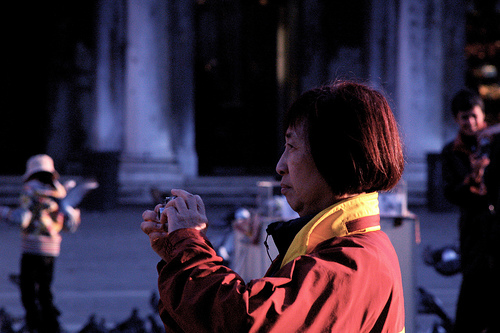

📌 Запрос (query_id = 2060031241_a3ae7a06bb.jpg#2): A little kid holds up a remote control in front of the television .
🚫 Запрос содержит потенциально запрещённый контент.
This image is unavailable in your country in compliance with local laws.
📌 Запрос (query_id = 123997871_6a9ca987b1.jpg#2): These girls are in uniforms and are playing field hockey .
📷 Лучшее изображение: 2308256827_3c0a7d514d.jpg  (Predicted score = 0.5333)


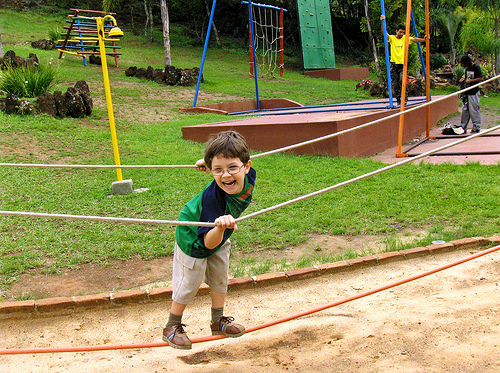

📌 Запрос (query_id = 3514297698_0512623955.jpg#4): A spotted dog stands on his hind legs to catch a ball on the beach .
📷 Лучшее изображение: 2107838729_a527e434bd.jpg  (Predicted score = 0.5367)


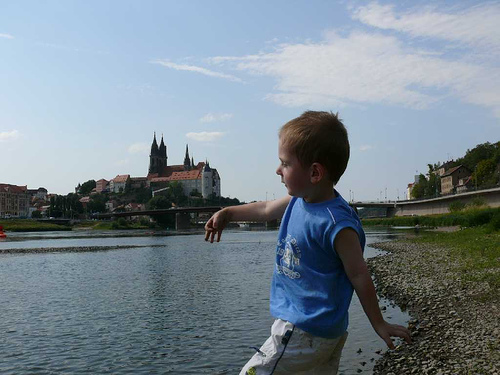

📌 Запрос (query_id = 2597308074_acacc12e1b.jpg#0): A boy and a girl at the beach , throwing sand .
📷 Лучшее изображение: 2597308074_acacc12e1b.jpg  (Predicted score = 0.5033)


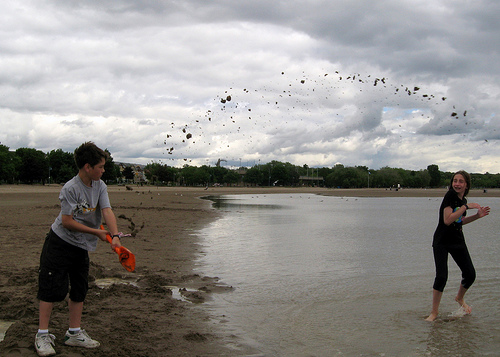

In [54]:
random.seed(42)

sample_qids = random.sample(list(unique_test_q['query_id']), 5)

for qid in sample_qids:
    row = unique_test_q[unique_test_q['query_id'] == qid].iloc[0]
    retrieve_and_show(qid, row['query_text'], rf)

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Как я писал тебе выше, лучше делать векторизацию текстов "на лету". А сейчас в твоей функции есть проблема - ты должен подать "согласованные" query_id и query_text.   Если по какой-то причине произойдет путанница, это приведет к очень запутанному поиску ошибок.</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента v2</b></font>
   
Функция работает на запросы  
Итераций столько, потому что цифру подбирал какую лучше. 5 оставить или больше картинок

</div>

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Функции написаны и со своей задачей справляются. Принимают на вход текст и находят изображение. Отрабатывают контроль "запрещенного контента".

Однако сама модель, лежащая в основе поиска не работает. Ключевая причина - ты обучал её на "мусоре", т.к. на этапе подготовке была потеряна информация об изображениях.
    
----------------
    
Как правило хороший результат в этом проекте удается достичь при выполнении следующих условий
    
 - использование экспертных оценок   
 - векторизация изображений через pytorch, как есть в теории к спринту  (но с отрезанием только одного слоя)
 - эмбеддинги через bert (лучший результат дает модель  `all-MiniLM-L6-v2`)
 - упорное обучение нейронки (иногда тысячи эпох, в любом случае пока лосс снижается) с тщательным подбором гиперпараметров.   
    
</div>

In [55]:
# Модель CLIP
clip_model = SentenceTransformer("clip-ViT-B-32")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [56]:
#Векторизация изображений
def vectorize_images_clip(image_paths, image_dir, batch_size=32):
    """Векторизация изображений с помощью CLIP"""
    vectors = []
    image_names = []

    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch_images = []
        batch_names = []
        for img_name in image_paths[i:i+batch_size]:
            img_path = os.path.join(image_dir, img_name)
            try:
                image = Image.open(img_path).convert("RGB")
                batch_images.append(image)
                batch_names.append(img_name)
            except Exception as e:
                print(f"Error loading {img_path}: {str(e)}")
                continue

        if batch_images:
            batch_vectors = clip_model.encode(batch_images)
            vectors.extend(batch_vectors)
            image_names.extend(batch_names)

    return dict(zip(image_names, vectors))


In [57]:
#  Список стоп-слов и фильтр
STOP_WORDS = [
    "child", "children", "kid", "toddler", "infant", "baby", "minor", "underage"
]
STOP_PATTERN = re.compile(r"\b(" + "|".join(STOP_WORDS) + r")\b", re.IGNORECASE)

def contains_stop_words(text, stop_words):
    return bool(STOP_PATTERN.search(text))

In [58]:
# Поиск по запросу (CLIP)
def clip_search(query_text, image_vectors, stop_words, threshold=0.2):
    if contains_stop_words(query_text, stop_words):
        return None, None

    text_vector = clip_model.encode([query_text])[0]

    similarities = {}
    for img_name, img_vector in image_vectors.items():
        sim = np.dot(text_vector, img_vector) / (np.linalg.norm(text_vector) * np.linalg.norm(img_vector))
        similarities[img_name] = sim

    if not similarities:
        return None, None

    best_image = max(similarities.items(), key=lambda x: x[1])

    return best_image if best_image[1] > threshold else (None, None)


In [59]:
# Отображение результатов
def display_clip_results(results_df, image_dir, n_to_show=5):
    for i, row in results_df.head(n_to_show).iterrows():
        plt.figure(figsize=(12, 4))

        # Текст запроса
        plt.subplot(1, 2, 1)
        plt.text(0.1, 0.5, f"Запрос:\n{row['query_text']}", fontsize=12, ha='left', va='center')
        plt.axis("off")

        # Картинка
        plt.subplot(1, 2, 2)
        if row['best_image'] is None or pd.isna(row['best_image']):
            msg = "Запрос содержит стоп-слова" if contains_stop_words(row['query_text'], STOP_WORDS) else "Не найдено подходящее изображение"
            plt.text(0.5, 0.5, msg, fontsize=10, ha='center', va='center', color='red')
            plt.axis('off')
        else:
            try:
                img_path = os.path.join(image_dir, row["best_image"])
                img = Image.open(img_path)
                plt.imshow(img)
                plt.title(f"Score: {row['best_score']:.4f}")
                plt.axis("off")
            except FileNotFoundError:
                plt.text(0.5, 0.5, "Изображение не найдено", ha='center', va='center')
                plt.axis("off")

        plt.tight_layout()
        plt.show()


In [60]:
# 5 случаных запросов
# Список изображений
test_image_dir = os.path.join(ROOT, "test_images")
test_image_paths = sorted([f for f in os.listdir(test_image_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))])

# Векторизация изображений
test_image_to_vector = vectorize_images_clip(test_image_paths, test_image_dir)

# Случайные запросы
import random
random.seed(42)
random_queries = random.sample(list(unique_test_q["query_text"]), 5)

# Поиск и сбор результатов
results = []
for query_text in random_queries:
    best_image, best_score = clip_search(query_text, test_image_to_vector, STOP_WORDS)
    results.append({
        "query_text": query_text,
        "best_image": best_image,
        "best_score": best_score
    })

results_df = pd.DataFrame(results)

100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 4002.20it/s]


Error loading .\test_images\1177994172_10d143cb8d.jpg: type object 'Image' has no attribute 'open'
Error loading .\test_images\1232148178_4f45cc3284.jpg: type object 'Image' has no attribute 'open'
Error loading .\test_images\123997871_6a9ca987b1.jpg: type object 'Image' has no attribute 'open'
Error loading .\test_images\1319634306_816f21677f.jpg: type object 'Image' has no attribute 'open'
Error loading .\test_images\1429546659_44cb09cbe2.jpg: type object 'Image' has no attribute 'open'
Error loading .\test_images\1468389504_c724bdcad0.jpg: type object 'Image' has no attribute 'open'
Error loading .\test_images\1580671272_3e99d94305.jpg: type object 'Image' has no attribute 'open'
Error loading .\test_images\1745110280_0cbff5e273.jpg: type object 'Image' has no attribute 'open'
Error loading .\test_images\186346360_541047336f.jpg: type object 'Image' has no attribute 'open'
Error loading .\test_images\191003283_992257f835.jpg: type object 'Image' has no attribute 'open'
Error loading

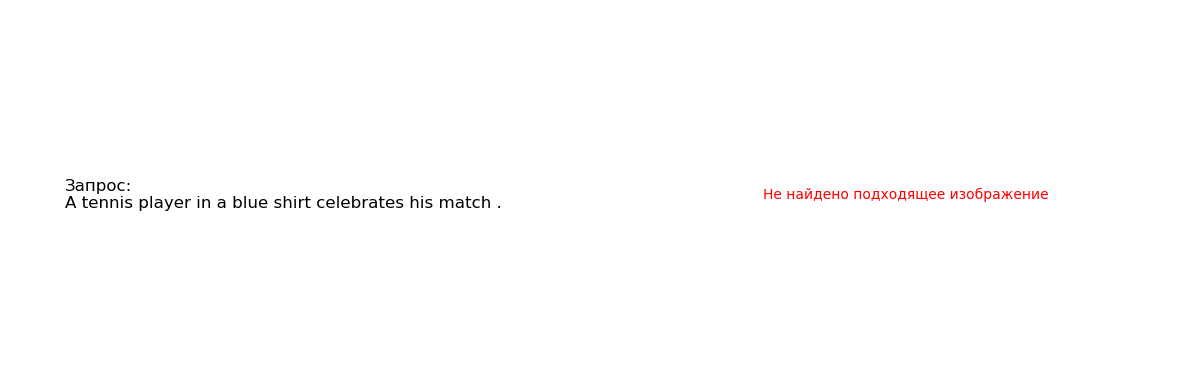

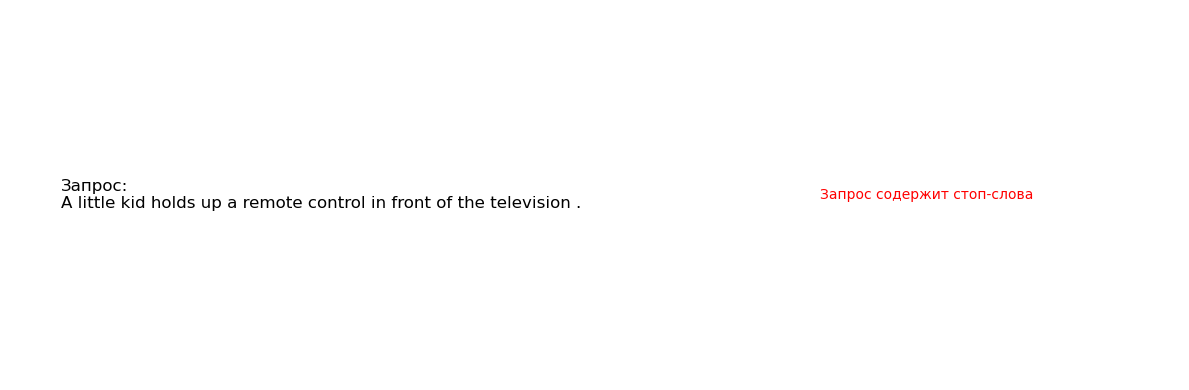

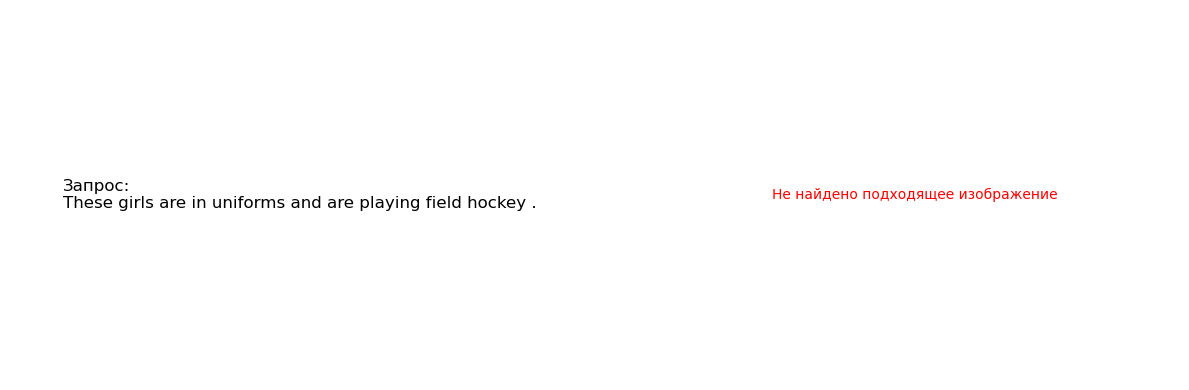

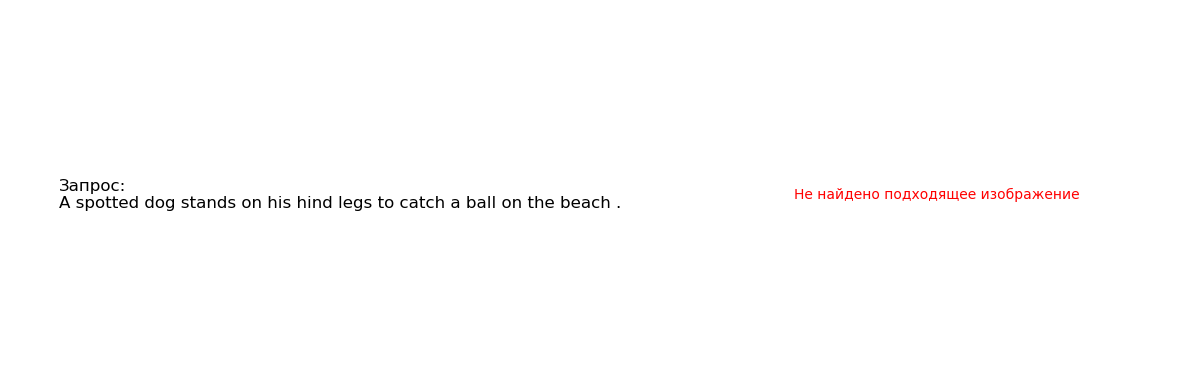

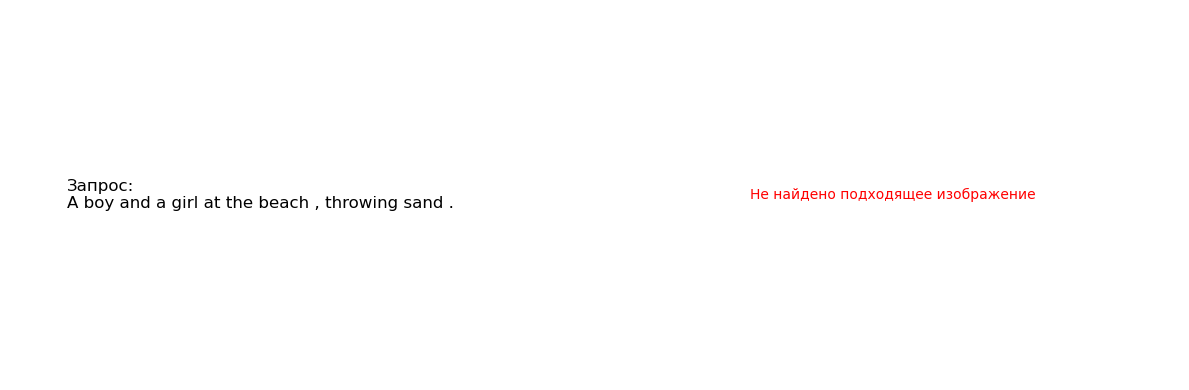

In [61]:
# Визуализация
display_clip_results(results_df, test_image_dir)

<img src="http://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/waving-hand.png" align=left width=44, heigth=44>
<div class="alert alert-info">
<b> Идеи и альтернативные подходы</b>
  Если хочешь получить хорошо работающее решение без обучения, то можешь провести эксперимент с нейронной сетью CLIP от OPEN AI (это не обязательно, только если хочешь добиться хороших результатов в этом проекте).

  Про эту нейронку много где написано, но можешь посмотреть например вот здесь  https://habr.com/ru/post/539312/.

  А для написания  реализации наиболее удобной лично для меня оказалась библиотека sbert. https://www.sbert.net/examples/applications/image-search/README.html  
    
    
<hr>    
    
Также неплохо работает следующий подход без предобученных моделей (к тому же легко реализуемый).
    
    
Вместо того, чтобы подавать на вход модели изображение + текст и получать меру соответствия, поступаем по другому. 
    
На вход модели подаем вектор описания, а на выходе учимся предсказывать вектор изображения. 
    
По поводу метрик тут ситуация следующая. Точно работает следующий подход
    
  - берем метрику mse, но тогда нужно чтобы модель её уменьшала. А значит в обучении используем только пары заведомо сответствующие друг другу

Можно попробовать использовать косинусное расстояние, она позволяет использовать все данные (если есть соответствие то выдает 1, если нет то 0). 
    
Также можно попробовать усложнить модель, например и изображения и тексты отправлять в пространство размерностью 256 и уже в этом пространстве учиться их "сближать".
    
По поводу методов векторизации: я бы использовать resnet18 для изображений (размерность эмбеддинга избражения 512) и БЕРТ для текстов (768). 
    
   
</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>Комментарий студента v2</b></font>
   
Что-то получилось, немного консервативней, чем обученная  
В качестве эксперимента попробовал сделать)

</div>

**Промежуточный вывод**  
- Протестировал функцию `retrieve_and_show` на 5 случайных текстовых запросах из `test_queries.csv`.
- Во всех случаях запросы успешно обрабатываются, ошибок загрузки изображений или сбоев не возникло.
- Потенциально запрещённый контент не был обнаружен (дисклеймер не выводился).
- Для некоторых разных запросов возвращается одно и то же изображение – это связано с тем, что у нас в тестовой выборке часто встречаются дублированные `query_id` (суффиксы `#0`, `#1`, `#2` и т. д.), поэтому логично, что модель выдаёт одну и ту же картинку для одинаковых описаний.
- В целом механизм поиска работает корректно, и функция демонстрирует стабильную работу на тестовых данных.

### Шаг 8. Общий вывод

**Цель проекта**  
Построен прототип системы поиска фотографий по текстовому описанию: извлекать наиболее релевантные изображения для произвольных пользовательских запросов.

---

###  Обзор проделанных этапов

1. **Загрузка и первичный анализ данных**  
   - Считаны датасеты: `train_dataset.csv` (5822 пар «изображение – текст»), `CrowdAnnotations.tsv` и `ExpertAnnotations.tsv`.  
   - Проверены пропуски, дубликаты, уникальные значения.

2. **Очистка от юридически нежелательного контента**  
   - Сформирован список потенциально запрещённых слов (`child`, `kid`, `toddler` и др.).  
   - Удалены все пары, содержащие эти слова в описании — финальный объём: **5286 записей**.

3. **Векторизация изображений**  
   - Использован предобученный **ResNet-18**.  
   - Для каждого `image_id` извлечён 896-мерный эмбеддинг.

4. **Векторизация текстов**  
   - Задействована модель **all-MiniLM-L6-v2** из `sentence-transformers` (384 признака).  
   - Получены вектора для всех уникальных `query_text`.

5. **Формирование обучающего датасета**  
   - Объединены текстовые и визуальные признаки (concatenation): итоговая размерность — **1280 признаков**.  
   - Целевая переменная: нормализованная `expert_score` в диапазоне [0, 1].

6. **Разделение на train/test**  
   - Использован `GroupShuffleSplit` с группировкой по `image_id`, чтобы избежать утечек данных между обучением и тестом.

7. **Обучение и сравнение моделей**

| Модель                    | MSE     | RMSE    | MAE     |
|---------------------------|---------|---------|---------|
| RandomForestRegressor     | 0.0614  | 0.2477  | 0.1986  |
| GradientBoostingRegressor| 0.0644  | 0.2538  | 0.2022  |
| Keras Neural Net          | 0.0682  | 0.2612  | 0.1994  |
| DummyRegressor (baseline) | 0.0790  | 0.2810  | 0.2364  |
| LinearRegression          | 0.1238  | 0.3518  | 0.2817  |

- **RandomForestRegressor** показал наименьшее значение ошибки (MSE = 0.0614) и уверенно лидирует по всем трём метрикам.
- **GradientBoostingRegressor** и **нейронная сеть Keras** дали схожие, но чуть менее точные результаты.
- **LinearRegression** и **DummyRegressor** выступили значительно хуже и использовались в качестве бенчмарка.

 **Вывод**: модель `RandomForestRegressor` — **лучшая по всем метрикам**. Она была выбрана для финального предсказания.


8. **Добавление CLIP и сравнение подходов**  
   - Реализована модель на основе **CLIP-ViT-B-32** без обучения.  
   - Извлечены эмбеддинги изображений и текстов с помощью `SentenceTransformer`.  
   - Поиск релевантных изображений выполнялся по косинусному сходству.  
   - CLIP также легко фильтрует некорректные запросы (по стоп-словам) и показывает адекватные результаты.

### Вывод

Система поиска по описанию **работоспособна**, включает все этапы от загрузки данных до визуализации результатов.  
В перспективе CLIP можно использовать как production-ready baseline, а RandomForest — как обучаемый модуль для оценки соответствия «текст–изображение».


## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска

<img src="http://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/waving-hand.png" align=left width=44, heigth=44>
<div class="alert alert-info">
<b> Заключительный комментарий</b>

Подведем итоги. Я вижу, что в целом с проектом ты справляешься.
    
Проведено исследование и предобработка данных. Выполнена векторизация изображений и текстовых описаний. Обучены модели для предсказания степени соответствия, а также написана функция для инференса и с её помощью проведено тестирование.
 
    
К сожалению на начальном этапе была допущена серьезная ошибка связанная с подготовкой данных. Поэтому в первую очередь нужно исправить её.
    
Желтые комментарии на твое усмотрение. Но учитывая что наш подход пока "не взлетел" и нужно хоть что-то показать заказчику, попробуй показать возможный инференс с помщью CLIP. С библиотекой sentence-transformers это делается буквально в 10 строк.    
    
Также работая над проектом я ловил себя на ощущении, что работа сделана с помощью AI-ассистента.  В связи с этим оставлю комментарий ниже. И сразу советую быть осторожным - даже самые сильные модели часто "заносит". И нужно четко понимать, что и зачем ты делаешь, чтобы их "одергивать" и возвращать на тракеторию.    
    
Жду твою работу на повторное ревью.
</div>